<a href="https://colab.research.google.com/github/thousandoaks/Intro-Causal-Inference/blob/main/code/DoWhy_Different_estimation_methods_for_causal_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install dowhy

     |████████████████████████████████| 123 kB 6.8 MB/s 
  Attempting uninstall: pydot
    Found existing installation: pydot 1.3.0
    Uninstalling pydot-1.3.0:
      Successfully uninstalled pydot-1.3.0


In [2]:
import numpy as np
import pandas as pd
import logging

import dowhy
from dowhy import CausalModel

import dowhy.datasets

In [4]:
## Beta is the true causal effect
data = dowhy.datasets.linear_dataset(beta=10,
        num_common_causes=5,
        num_instruments = 2,
        num_treatments=1,
        num_samples=10000,
        treatment_is_binary=True,
        outcome_is_binary=False)
df = data["df"]
df


,Z0,Z1,W0,W1,W2,W3,W4,v0,y
0,1.0,0.458519,0.469715,0.332473,-0.107062,-0.437093,-0.415828,True,9.342736
1,0.0,0.295741,1.718528,0.428701,0.677722,-0.240408,-0.011656,True,16.611057
2,0.0,0.325931,1.816101,1.084933,0.099020,0.545320,-0.915553,True,18.929524
3,0.0,0.509428,1.125953,0.075756,-0.311416,-0.453836,-0.713342,True,9.113318
4,0.0,0.509648,0.416884,-0.335813,1.483623,-0.713708,1.289199,True,13.707355
...,...,...,...,...,...,...,...,...,...
9995,1.0,0.478965,1.681176,-1.533072,0.048683,0.272072,0.270129,True,11.613124
9996,0.0,0.165133,0.018046,1.365422,-1.491530,1.012305,0.034717,True,12.811790
9997,1.0,0.551771,-0.066355,0.462090,-1.136945,-0.177306,1.123492,True,7.577513
9998,1.0,0.323011,1.474459,2.055573,-1.980787,0.951408,-0.926566,True,15.120834


In [5]:
# With graph
model=CausalModel(
        data = df,
        treatment=data["treatment_name"],
        outcome=data["outcome_name"],
        graph=data["gml_graph"],
        instruments=data["instrument_names"]
        )

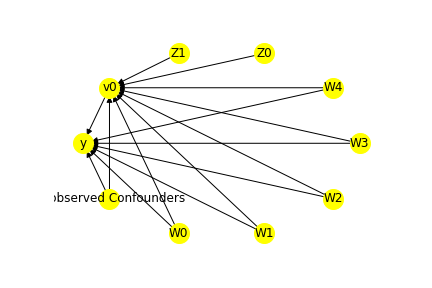

In [7]:
from IPython.display import Image, display
display(Image(filename="causal_model.png"))


In [8]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
─────(Expectation(y|W3,W0,W4,W1,W2))
d[v₀]                               
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W0,W4,W1,W2,U) = P(y|v0,W3,W0,W4,W1,W2)

### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, [Z0, Z1])*Derivative([v0], [Z0, Z1])**(-1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z0,Z1})
Estimand assumption 2, Exclusion: If we remove {Z0,Z1}→{v0}, then ¬({Z0,Z1}→y)

### Estimand : 3
Estimand name: frontdoor
No such variable found!



# Method 1: Regression

In [9]:
causal_estimate_reg = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression",
        test_significance=True)
print(causal_estimate_reg)
print("Causal Estimate is " + str(causal_estimate_reg.value))


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
─────(Expectation(y|W3,W0,W4,W1,W2))
d[v₀]                               
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W0,W4,W1,W2,U) = P(y|v0,W3,W0,W4,W1,W2)

## Realized estimand
b: y~v0+W3+W0+W4+W1+W2
Target units: ate

## Estimate
Mean value: 10.000088984617479
p-value: [0.]

Causal Estimate is 10.000088984617479


In [10]:
res_random=model.refute_estimate(identified_estimand, causal_estimate_reg, method_name="random_common_cause")
print(res_random)

Refute: Add a Random Common Cause
Estimated effect:10.000088984617479
New effect:10.000088739349355



In [11]:
res_placebo=model.refute_estimate(identified_estimand, causal_estimate_reg,
        method_name="placebo_treatment_refuter", placebo_type="permute")
print(res_placebo)

Refute: Use a Placebo Treatment
Estimated effect:10.000088984617479
New effect:-0.009231387449292186
p value:0.5



# Method 2: Stratification

In [12]:
causal_estimate_strat = model.estimate_effect(identified_estimand,
                                              method_name="backdoor.propensity_score_stratification",
                                              target_units="att")
print(causal_estimate_strat)
print("Causal Estimate is " + str(causal_estimate_strat.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
─────(Expectation(y|W3,W0,W4,W1,W2))
d[v₀]                               
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W0,W4,W1,W2,U) = P(y|v0,W3,W0,W4,W1,W2)

## Realized estimand
b: y~v0+W3+W0+W4+W1+W2
Target units: att

## Estimate
Mean value: 10.128451612406556

Causal Estimate is 10.128451612406556


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [13]:
res_random=model.refute_estimate(identified_estimand, causal_estimate_strat, method_name="random_common_cause")
print(res_random)

Refute: Add a Random Common Cause
Estimated effect:10.128451612406556
New effect:10.13201784387604



/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [14]:
res_placebo=model.refute_estimate(identified_estimand, causal_estimate_strat,
        method_name="placebo_treatment_refuter", placebo_type="permute")
print(res_placebo)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

Refute: Use a Placebo Treatment
Estimated effect:10.128451612406556
New effect:-0.0014127021223702646
p value:0.45999999999999996

